In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model  
from loss import custom_loss_wrapper
import os 
import h5py
import glob


2025-07-10 01:06:43.098759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_dir = '/home/users/dprimosc/L1METML/experiments/l1metml_v1/25May21_normf100_clip_140X/'
model_name = '25May21_normf100_clip_140Xmodel.h5'
model = load_model(model_dir + model_name, custom_objects={'custom_loss':custom_loss_wrapper})


In [5]:
# Pre-processing done in .h5 conversion
sample = 'MinBias' 
tag = '25Jul8_140X_v0'
data_dir = f'/ceph/cms/store/user/dprimosc/l1deepmet_data/{tag}/{sample}_PU200/FP/140Xv0/'
h5_files = glob.glob(os.path.join(data_dir, f'*.h5'))

      

In [6]:
# Load and concatenate data from all files
X_data_list = []
Y_data_list = []

for h5_file in h5_files:
    print(f"Loading {os.path.basename(h5_file)}...")
    with h5py.File(h5_file, 'r') as f:
        # Check what datasets are available
        if len(X_data_list) == 0:  # Only print once
            print("Datasets in file:", list(f.keys()))
        
        # Load X and Y data
        X_batch = f['X'][:]  # Shape: (n_events, n_particles, n_features)
        Y_batch = f['Y'][:]  # Shape: (n_events, 2)
        
        X_data_list.append(X_batch)
        Y_data_list.append(Y_batch)
        print(f"  Loaded {X_batch.shape[0]} events")

# Concatenate all data
data = np.concatenate(X_data_list, axis=0)  # Shape: (total_events, n_particles, n_features)
Y = np.concatenate(Y_data_list, axis=0)     # Shape: (total_events, 2)

print(f"\nTotal concatenated data shape: {data.shape}")
print(f"Total target shape: {Y.shape}")
print(f"Total events: {data.shape[0]}")

Loading perfNano_12509504_154.h5...
Datasets in file: ['X', 'Y']
  Loaded 16319 events
Loading perfNano_12509504_119.h5...
  Loaded 2559 events
Loading perfNano_12509504_61.h5...
  Loaded 1759 events
Loading perfNano_12509504_71.h5...
  Loaded 16319 events
Loading perfNano_12509504_125.h5...
  Loaded 2559 events
Loading perfNano_12509504_85.h5...
  Loaded 16319 events
Loading perfNano_12509504_34.h5...
  Loaded 16319 events
Loading perfNano_12509504_43.h5...
  Loaded 16319 events
Loading perfNano_12509504_144.h5...
  Loaded 16319 events
Loading perfNano_12509504_66.h5...
  Loaded 2239 events
Loading perfNano_12509504_62.h5...
  Loaded 3199 events
Loading perfNano_12509504_129.h5...
  Loaded 1759 events
Loading perfNano_12509504_130.h5...
  Loaded 2079 events
Loading perfNano_12509504_63.h5...
  Loaded 3199 events
Loading perfNano_12509504_88.h5...
  Loaded 16319 events
Loading perfNano_12509504_23.h5...
  Loaded 16319 events
Loading perfNano_12509504_96.h5...
  Loaded 15039 events
Load

In [28]:

with h5py.File(os.path.join(data_dir, data_file), 'r') as f:
    # List all datasets in the file
    print("Datasets in file:", list(f.keys()))
    # Load the first dataset as an example
    first_key = list(f.keys())[0]
    data = f[first_key][:]
    print(f"Shape of dataset '{first_key}':", data.shape)

Datasets in file: ['X', 'Y']
Shape of dataset 'X': (18999, 128, 8)


In [7]:
# Assuming 'data' is loaded and has shape (batch_size, 128, >=8)
# Reconstruct X0-X3 from the 'data' array according to the encoding

# X0: pt, pt*cos(phi), pt*sin(phi), eta
X0 = data[:, :, [0, 1, 2, 3]]

# X1: phi, puppiw
X1 = data[:, :, [4, 5]]

# X2: encoded pdgId
X2 = data[:, :, 6].astype(int)

# X3: encoded charge
X3 = data[:, :, 7].astype(int)

In [8]:
# Ensure X2 and X3 indices are within the valid range for the embedding layer
#X2_clipped = np.clip(X2, 0, 3)
#X3_clipped = np.clip(X3, 0, 3)

# Run inference
predictions = model.predict([X0, X1, X2, X3])


62410/62410 [==============================] - 84s 1ms/step


In [9]:
print(predictions)

[[  1.6814235  20.799322 ]
 [-10.182047   32.73009  ]
 [  6.556045   15.122197 ]
 ...
 [  5.8402076  16.159794 ]
 [-24.642181   24.030445 ]
 [-10.341343   23.712786 ]]


In [10]:
# Calculate the magnitude (Euclidean norm) of each prediction vector
prediction_magnitudes = np.linalg.norm(predictions, axis=1)
print(prediction_magnitudes)

[20.867174 34.277294 16.48219  ... 17.182753 34.419464 25.869665]


In [33]:
#Tarray_PU = np.load(os.path.join(model_dir, "25May21_normf100_clip_140XTTbar_feature_array_PUMET.npy"))
#Tarray_PU_target = np.load(os.path.join(model_dir, "25May21_normf100_clip_140XTTbar_target_array_PUMET.npy"))

In [ ]:
# Save predictions as the feature array
np.save(os.path.join(model_dir, f"{sample}_feature_array_MLMET.npy"), predictions)

# Save the target array Y 
np.save(os.path.join(model_dir, f"{sample}_target_array_MLMET.npy"), Y)


In [13]:
#TODO: check for correctness
# Compute PUPPI MET prediction using input features
# px = pt * cos(phi), py = pt * sin(phi), puppiw = X1[..., 1]
# X0[..., 1] = pt*cos(phi), X0[..., 2] = pt*sin(phi), X1[..., 1] = puppiw

# Sum over all particles for each event: MET_px = -sum(puppiw * px), MET_py = -sum(puppiw * py)
puppi_px = X1[..., 1] * X0[..., 1]
puppi_py = X1[..., 1] * X0[..., 2]
puppi_met_pred = np.stack([
    -np.sum(puppi_px, axis=1),
    -np.sum(puppi_py, axis=1)
], axis=1)

# Save PUPPI MET predictions as the feature array
np.save(os.path.join(model_dir, f"{sample}_feature_array_PUMET.npy"), puppi_met_pred)

# Save the target array for PUPPI MET
np.save(os.path.join(model_dir, f"{sample}_target_array_PUMET.npy"), Y)

In [36]:
# Count number of events in TTbar and SingleNeutrino datasets
#ttbar_events = Tarray_PU.shape[0]
#singleneutrino_events = predictions.shape[0]

#print(f"Number of TTbar events: {ttbar_events}")
#print(f"Number of SingleNeutrino events: {singleneutrino_events}")

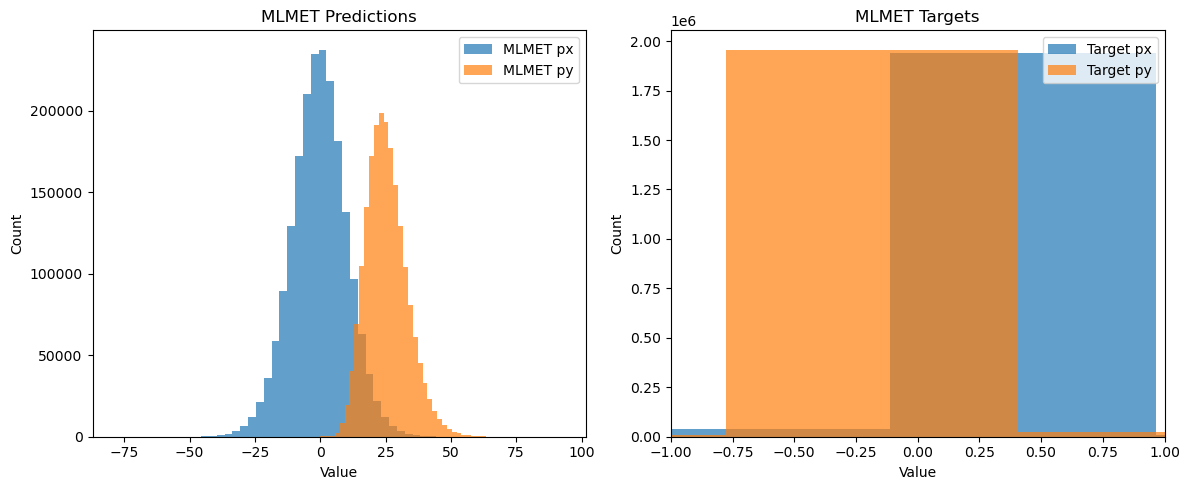

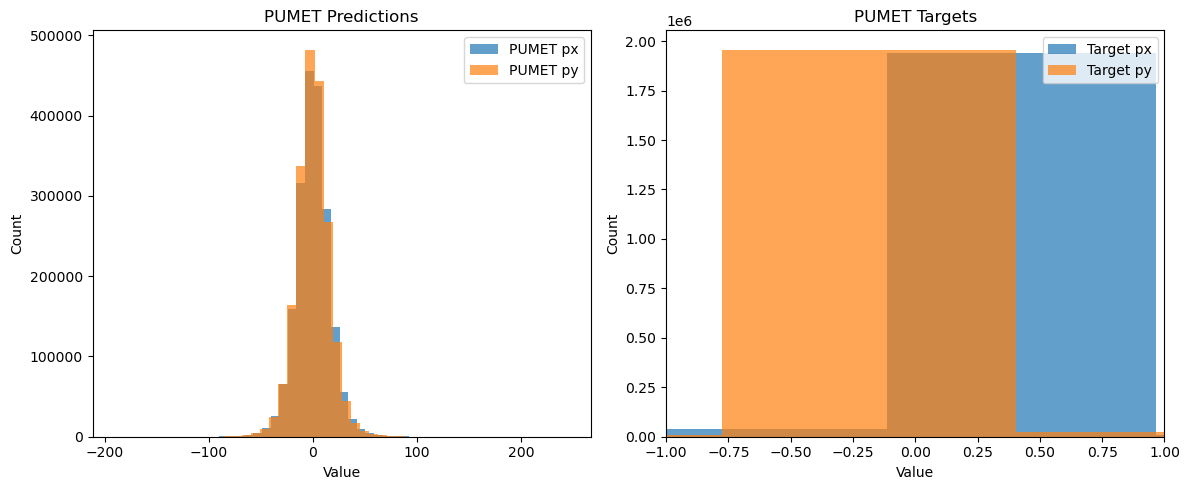

In [14]:
import matplotlib.pyplot as plt

# Plot histogram for predictions (MLMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(predictions[:, 0], bins=50, alpha=0.7, label='MLMET px')
plt.hist(predictions[:, 1], bins=50, alpha=0.7, label='MLMET py')
plt.title('MLMET Predictions')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

# Plot histogram for Y (MLMET target array)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=50, alpha=0.7, label='Target px')
plt.hist(Y[:, 1], bins=50, alpha=0.7, label='Target py')
plt.title('MLMET Targets')
plt.xlabel('Value')
plt.xlim(-1,1)
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram for puppi_met_pred (PUMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(puppi_met_pred[:, 0], bins=50, alpha=0.7, label='PUMET px')
plt.hist(puppi_met_pred[:, 1], bins=50, alpha=0.7, label='PUMET py')
plt.title('PUMET Predictions')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

# Plot histogram for Y (PUMET target array, same as above)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=50, alpha=0.7, label='Target px')
plt.hist(Y[:, 1], bins=50, alpha=0.7, label='Target py')
plt.title('PUMET Targets')
plt.xlabel('Value')
plt.xlim(-1,1)
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:


# Create a new model with all layers after layer 13 removed

# Get the output of layer 13 (indexing starts from 0)
layer_w_out = model.layers[14].output

# Create a new model from the same inputs to the output of layer 13
model_w = Model(inputs=model.input, outputs=layer_w_out)

# Run inference using the new model
predictions_w = model_w.predict([X0, X1, X2, X3])

62410/62410 [==============================] - 87s 1ms/step


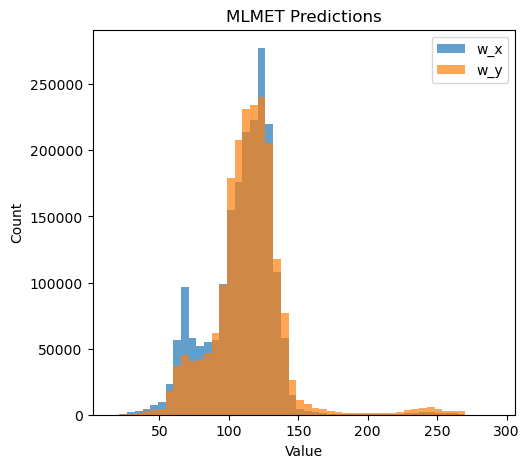

In [16]:
# Plot histogram for MET weights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(predictions_w[:, 0], bins=50, alpha=0.7, label='w_x')
plt.hist(predictions_w[:, 1], bins=50, alpha=0.7, label='w_y')
plt.title('MLMET Predictions')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()